In [1]:
import scipy
import torch
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utility_loader
from metrics import tf_counts_corr, tf_profile_auprc
from bpnetlite.performance import pearson_corr
from custom_bpnet import customBPNet
from tangermeme.ersatz import shuffle, dinucleotide_shuffle, randomize
from plotnine import *
import plotnine
import sklearn.metrics as skm
import tqdm

# Set outdir
outdir_models = '/data/mariani/specificity_bpnet/output/calibrated_models_5kb'

if not os.path.exists(outdir_models):
	os.makedirs(outdir_models)


In [ ]:
# Make predictions for each protein
folds_list = ['0', '1', '2']
#model_list = ['CBX7', 'KDM2B', 'MTF2', 'PCGF1', 'PCGF2', 'PCGF6', 'RING1B', 'RYBP', 'SUZ12']
model_list = ['PCGF2']

data_dir='/data/mariani/specificity_bpnet/folds/'
models_dir='/data/mariani/specificity_bpnet/single_models'

corr_df = pd.DataFrame(columns=['method', 'fold', 'task', 'pearson'])
for task in model_list:
	for fold in folds_list:
		test_data = utility_loader.bpnet_DataLoader(
			hdf5_tensor=os.path.join(data_dir, f'{task}_5kb', f'fold_{fold}/test_data_fold_{fold}.hdf5'),
			in_window=6114, out_window=5000, random_state=0, num_workers=4, 
			batch_size=1024, max_jitter=0, reverse_complement=False
		)

		name_model=f'{task}_calibrated_5kb'

		if task in ['PCGF1', 'PCGF2']:
			alpha = 10
		else:
			alpha = 300

		BPNet_dict = {
			"n_outputs":2,
			"n_control_tracks":2,
			"trimming":(6114-5000)//2,
			"alpha": alpha, # Alpha RYBP = X, PCGF1/2 = 10, others 300
			"n_filters": 128,
			"n_layers":13,
			"name": os.path.join(outdir_models, f'fold_{fold}', name_model)
		}
		# Create output model dirs
		if not os.path.exists(os.path.join(outdir_models, f'fold_{fold}', name_model)):
			os.makedirs(os.path.join(outdir_models, f'fold_{fold}', name_model))

		model = customBPNet(**BPNet_dict).cuda()

		# Loaded model state dict
		model.load_state_dict(torch.load(f'{models_dir}/{name_model}/fold_{fold}/{name_model}.torch', weights_only = True))
		
		# Calculate counts correlation 
		task_corr = tf_counts_corr(model, test_data, task, fold)
		corr_df = pd.concat([corr_df, task_corr])


# Pearson Correlation per Task

/data/mariani/bpnet_lite/lib64/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 5 in image.
/data/mariani/bpnet_lite/lib64/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /data/mariani/specificity_bpnet/output/models_hyperparams/calibrated_model/figs/total-counts.pdf
/data/mariani/bpnet_lite/lib64/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 5 in image.
/data/mariani/bpnet_lite/lib64/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /data/mariani/specificity_bpnet/output/models_hyperparams/calibrated_model/figs/total-counts.png


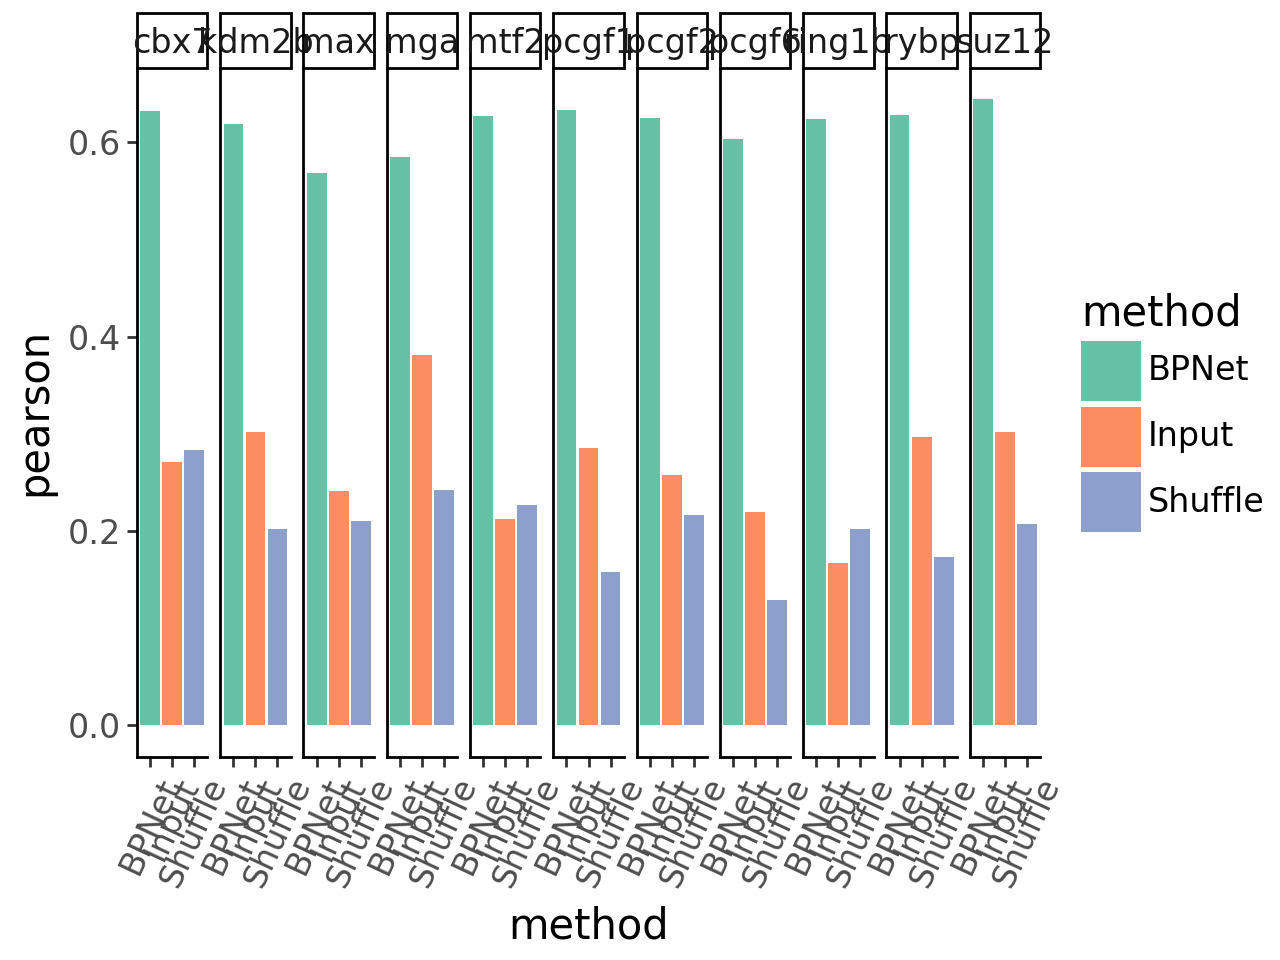

In [4]:

figure = (ggplot(df_correlation, aes(x='method', y='pearson', fill='method')) +
geom_bar(stat='identity', position='dodge') +
theme_classic(base_size=15) +
scale_fill_brewer(type='qualitative', palette=7) +
facet_grid('. ~ task') +
theme(axis_text_x=(element_text(angle=65)))
)

figure.save(f"{outdir}/total-counts.pdf", height=5, width=12)
figure.save(f"{outdir}/total-counts.png", height=5, width=12, dpi=300)

figure

# Binned auPRC per Task

In [4]:
auprc_df = tf_profile_auprc(loaded_model, test_data, test_annot_regions)

Test MNLL	Test Profile Pearson	Test Count Pearson	Test Count MSE
736.4825	0.06986549	0.62476194	1.3031


100%|██████████| 11/11 [00:05<00:00,  2.16it/s]


/data/mariani/bpnet_lite/lib64/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 16 x 4 in image.
/data/mariani/bpnet_lite/lib64/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /data/mariani/specificity_bpnet/output/models_hyperparams/calibrated_model/figs/auprc_test_regions.png
/data/mariani/bpnet_lite/lib64/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 16 x 4 in image.
/data/mariani/bpnet_lite/lib64/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /data/mariani/specificity_bpnet/output/models_hyperparams/calibrated_model/figs/auprc_test_regions.pdf


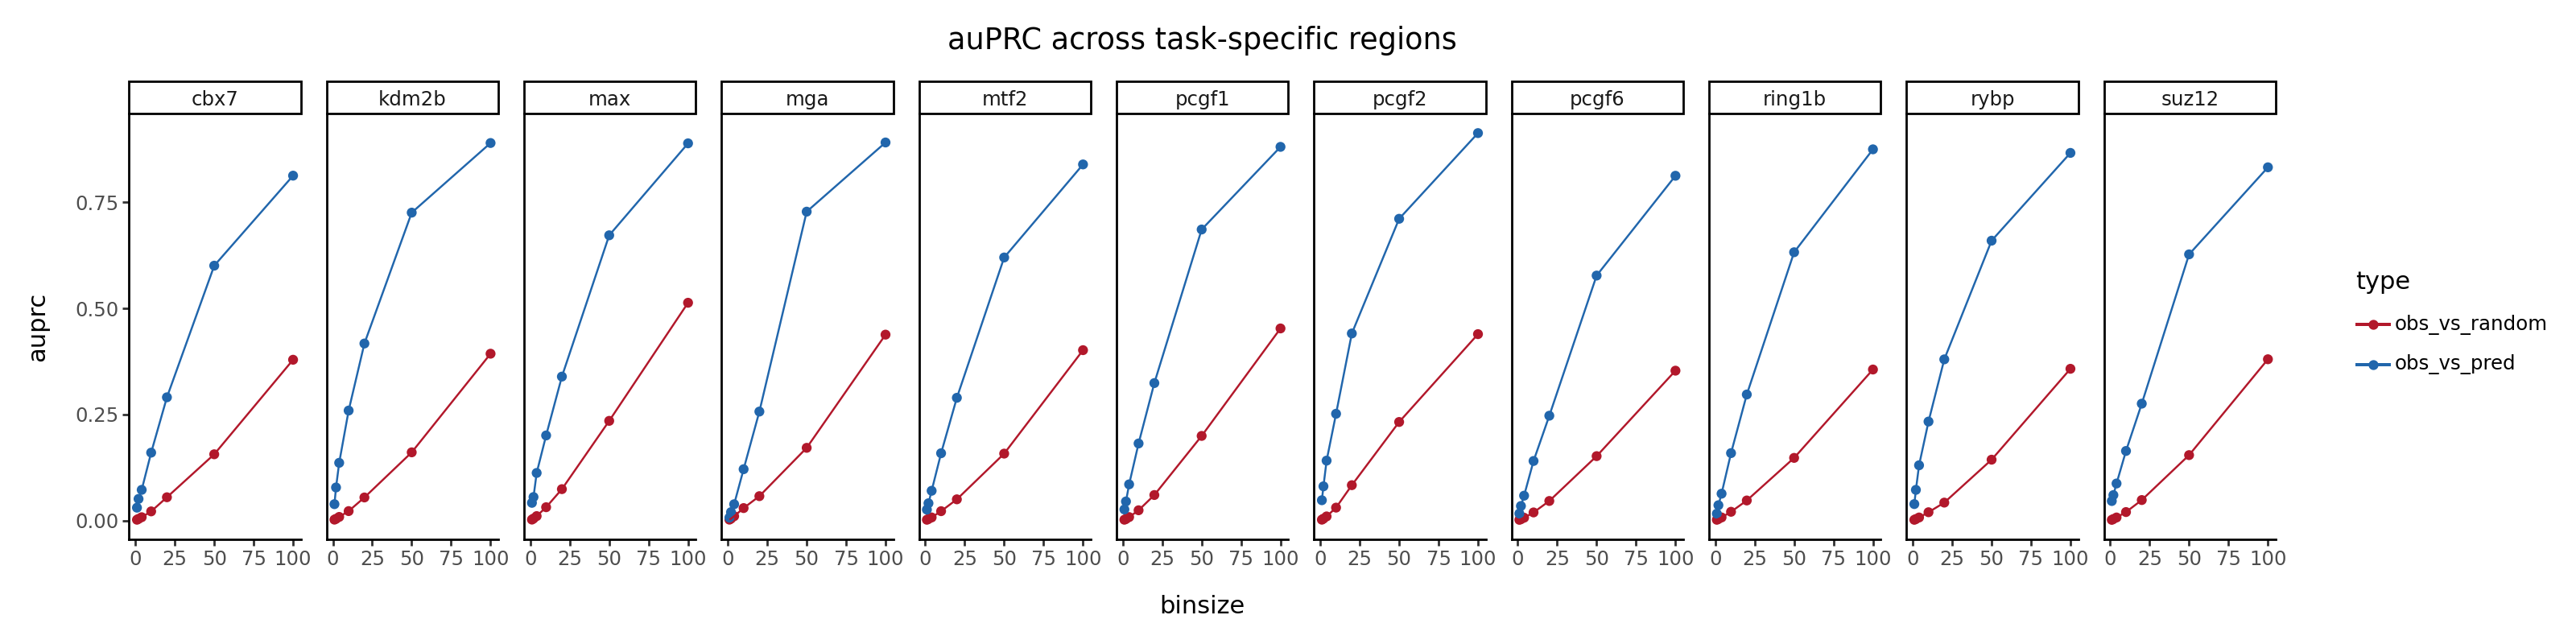

In [6]:
%matplotlib inline
plotnine.options.figure_size = (16,4)

auprc_df['type'] = pd.Categorical(auprc_df['type'], 
                                  categories=['obs_vs_random', 'obs_vs_pred'], 
                                  ordered=False)

fig = (ggplot(data = auprc_df, mapping = aes(x = 'binsize',y='auprc'))+
    geom_point(mapping = aes(color = 'type'))+
    geom_line(mapping = aes(color = 'type'))+
    scale_color_manual(values = ['#b2182b', '#2166ac'])+
    facet_grid('. ~ task')+
    ggtitle('auPRC across task-specific regions')+
    theme_classic())
fig.save(f'{outdir}/auprc_test_regions.png', height = 4, width = 16)
fig.save(f'{outdir}/auprc_test_regions.pdf', height = 4, width = 16)
fig